In [12]:
from gensim import corpora
from gensim import models
import numpy as np
from scipy.sparse import csr_array
import os
import matplotlib.pyplot as plt
import seaborn as sns
import time
from motifs.features import bow_to_matrix, bow_to_dataframe
import json
import pandas as pd

# Load data

In [7]:
data_path = "../data/canon"
docs = os.listdir(f"{data_path}/tokens_canon")

# Metadata
metadata = pd.read_csv(f"{data_path}/metadata.csv", index_col=0)
docs = [d for d in docs if d in metadata["doc_id"].tolist()]


SEGMENTS = [
    [1800, 1826],
    [1827, 1850],
    [1851, 1869],
    [1870, 1899],
    [1900, 1945],
    [1946, 2024],
]
SEGMENTS = pd.DataFrame(SEGMENTS, columns=["start", "end"])
s_seg = 50


def get_seg_from_date(date, segments):
    return segments[(segments["start"] <= date) & (date <= segments["end"])].index[0]
    
metadata["segment"] = metadata["date_publication"].apply(lambda x: get_seg_from_date(x, SEGMENTS))
metadata.doc_id = metadata.doc_id.str.replace(".csv", "")
metadata

,doc_id,titre,author,sexe,birth_date,death_date,date_publication,etiquette,segment
X,,,,,,,,,
7,1816_Barthelemy-Hadot-Marie-Adelaide_La-Vierge...,"La Vierge de l'Indostan, ou les Portugais au M...","Barthélemy-Hadot, Marie-Adélaïde",female,1763,1821,1816,non-canon,0
9,1816_Bournon-Malarme-Charlotte-de_Lancelot-Mon...,"Lancelot Montagu, ou le Résultat des bonnes fo...","Bournon-Malarme, Charlotte de",female,1753,1830,1816,non-canon,0
12,1817_Barthelemy-Hadot-Marie-Adelaide_Les-venit...,"Les Vénitiens, ou le Capitaine français (Tome 1)","Barthélemy-Hadot, Marie-Adélaïde",female,1763,1821,1817,non-canon,0
13,1817_Barthelemy-Hadot-Marie-Adelaide_Les-Venit...,"Les Vénitiens, ou le Capitaine français (Tome 2)","Barthélemy-Hadot, Marie-Adélaïde",female,1763,1821,1817,non-canon,0
18,1821_Arlincourt-Charles-Victor_Le-Solitaire,Le Solitaire,"Arlincourt, Charles-Victor Prévost d'",male,1788,1856,1821,non-canon,0
...,...,...,...,...,...,...,...,...,...
2231,1955_Veuzit-Max-du_A-l'ombre-d'un-coeur,A l'ombre d'un coeur,"Vavasseur, Alphonsine Zéphirine dite du Veuzit...",female,1876,1952,1955,non-canon,5
2234,1956_Delly_La-biche-au-bois,La biche au bois,"Petitjean de la Rosière, Jeanne-Marie",female,1875,1947,1956,non-canon,5
2411,1971_Veuzit-Max-du_Rien-qu'une-nuit,Rien qu'une nuit,"Vavasseur, Alphonsine Zéphirine dite du Veuzit...",female,1876,1952,1951,non-canon,5


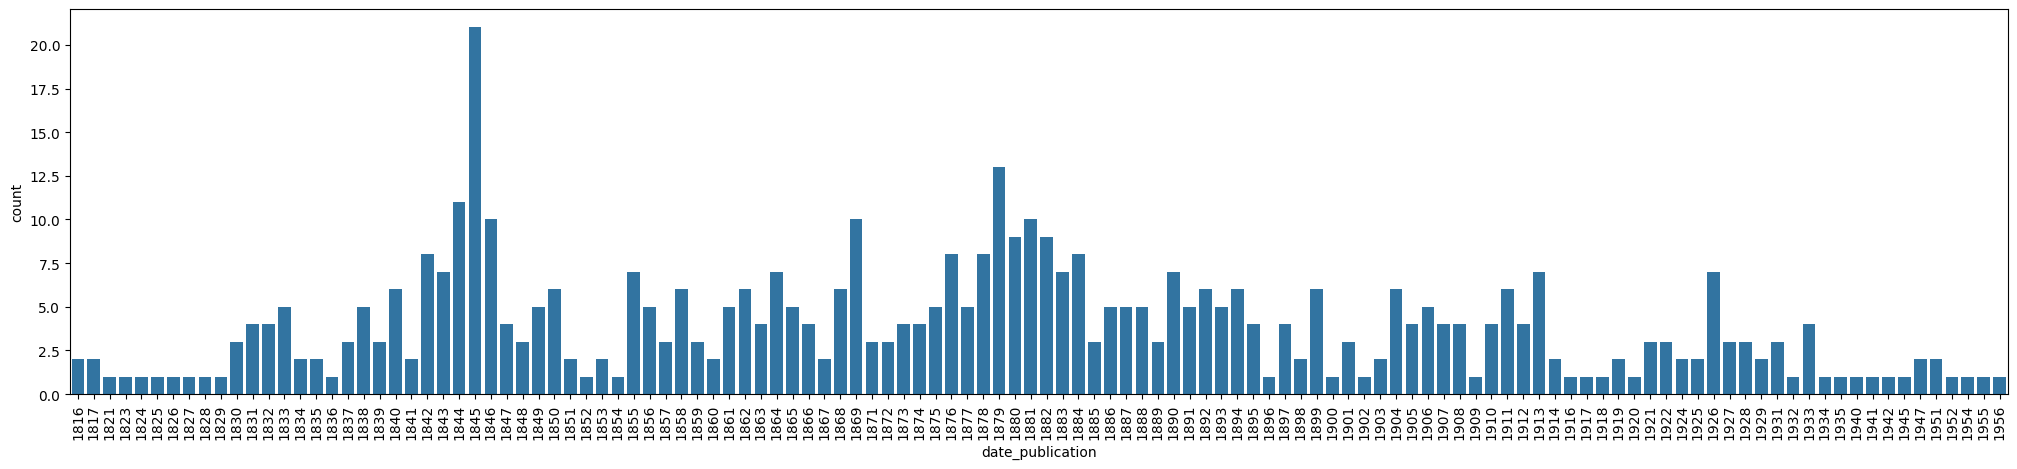

In [8]:
plt.figure(figsize=(25,5))
sns.barplot(metadata["date_publication"].value_counts())
plt.xticks(rotation=90)
plt.show()

# Get ngrams

In [46]:
ngrams = pd.read_csv("/Users/brunospilak/Documents/Sorbonne/PyMotifs/data_backup/ngrams_canon.csv", index_col=0)
docs = list(set(ngrams.doc.unique()))
tokeep = ngrams.groupby("doc")["token"].value_counts()
tokeep = tokeep[tokeep > 1]
ngrams = ngrams.set_index(["doc", "token"]).loc[tokeep.index].reset_index()
texts = [
    ngrams[ngrams["doc"] == d]["token"].tolist() for d in docs
]
segments = metadata.set_index("doc_id").loc[docs, "segment"]

# Compute TFIDF

In [37]:
t1 = time.time()
dictionary = corpora.Dictionary(texts)
bow_corpus = [dictionary.doc2bow(text) for text in texts]
t2 = time.time()
print(t2-t1)

# train the model
t1 = time.time()
model = models.TfidfModel(bow_corpus)
t2 = time.time()
print(t2-t1)

t1 = time.time()
mat_tfidf = bow_to_matrix([model[d] for d in bow_corpus], shape=(len(bow_corpus), len(dictionary.token2id)))
t2 = time.time()
print(t2-t1)
columns=list({id_: dictionary[id_] for id_ in dictionary.token2id.values()}.values())
index=docs

# Keep approximately the n less sparse features
n = 10000
freq_nonzeros = np.sum(mat_tfidf.toarray() != 0, axis=0) / mat_tfidf.shape[0]
mask = freq_nonzeros >= np.quantile(freq_nonzeros, 1 - n/mat_tfidf.shape[-1]) # 0.05

features = mat_tfidf[:,mask]
features.shape

4.278705835342407
0.6646327972412109
3.889601707458496


(217, 10075)

# Clustering

We have roughly 10000 features and 217 documents. The features are TFIDF features, thus definitely not gaussian. We can expect KMeans to perform very badly on the raw table. On top, we can suspect non-linear relationship between the documents.

We propose to use a manifold learning techning, TSNE, to reduce the dimension of the feature spaces. TSNE helps use to visualize potential clusters in the dataset.

In [38]:
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans, SpectralClustering, DBSCAN
from sklearn.manifold import TSNE
from sklearn import metrics

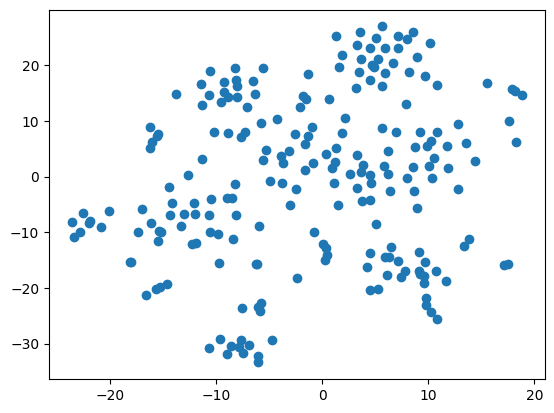

In [43]:
# First, we normalize each TFIDF vector
random_state=1
X = normalize(features, norm='l2', axis=1)
embedding = TSNE(
        n_components=2, learning_rate=10, 
        init='random', early_exaggeration=50,
        perplexity=10, random_state=random_state
).fit_transform(X)
plt.scatter(x=embedding[:,0], y=embedding[:,1])
plt.show()

We can observe some clusters. For example, one could see the following 7 groups that look dense and distant from the center of the point cloud:

![tnse_embedding.png](./tnse_embedding.png)

We will compare three methods for clustering: KMeans, SpectralClustering which requires a specific number of clusters, and DBSCAN, that determines the optimal number of clusters. We can expect KMeans to have difficulties at finding small clusters like the bottom left one.

Silhouette Kmeans 0.4262159


/Users/brunospilak/miniconda3/envs/pymotifs/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:411: UserWarning: Exited at iteration 2000 with accuracies 
[1.74150407e-13 2.27230131e-07 2.11504285e-07 1.46932394e-06
 5.47887090e-07 1.46847389e-06 3.83345712e-07 9.37967316e-06
 7.06749202e-06]
not reaching the requested tolerance 3.2335519790649414e-06.
Use iteration 1967 instead with accuracy 
1.447829634340743e-06.

  _, diffusion_map = lobpcg(
/Users/brunospilak/miniconda3/envs/pymotifs/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:411: UserWarning: Exited postprocessing with accuracies 
[6.04378292e-14 2.23023178e-07 1.90267064e-07 1.11956339e-06
 4.54082874e-07 1.24553205e-06 2.64475012e-07 5.61156386e-06
 3.92261924e-06]
not reaching the requested tolerance 3.2335519790649414e-06.
  _, diffusion_map = lobpcg(


Silhouette Spectral 0.0005881039
Silhouette DBSCAN 0.25119492


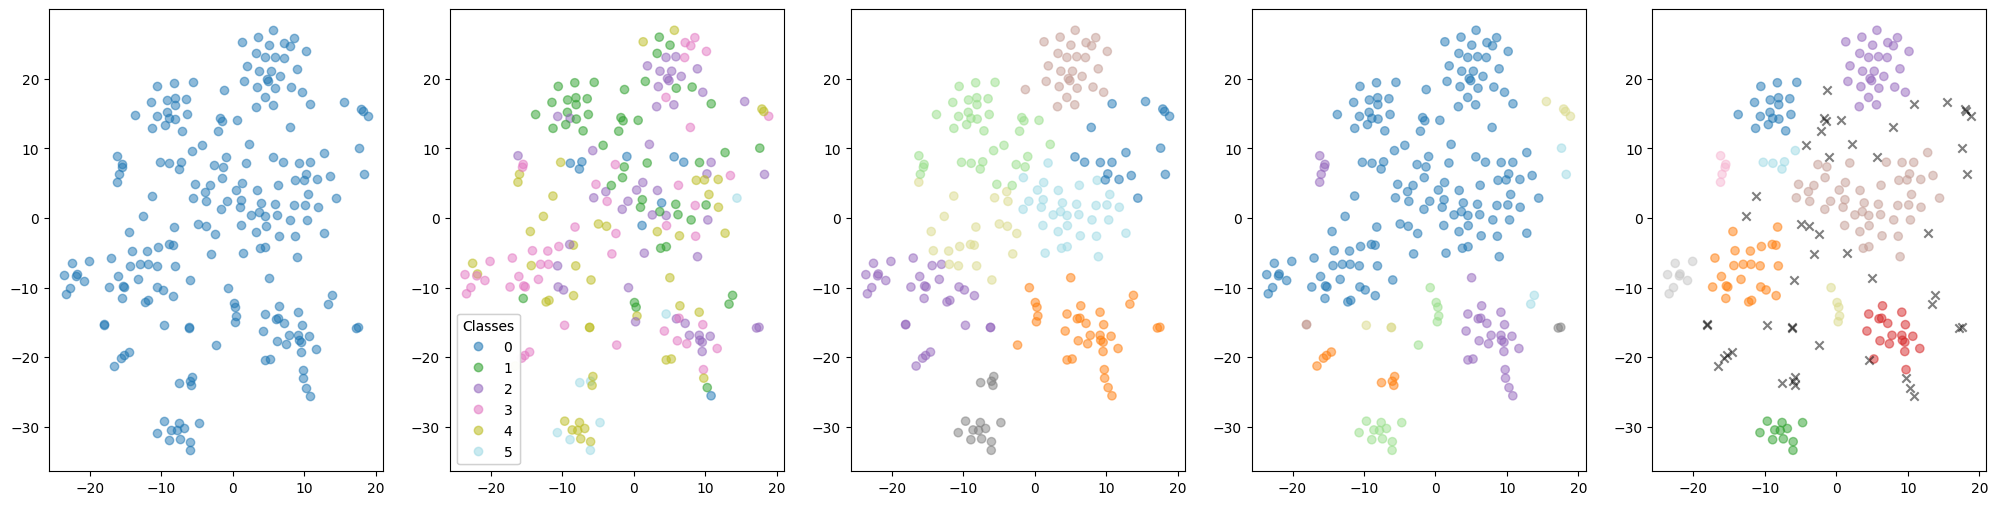

In [68]:
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters, random_state=random_state).fit(embedding)
print("Silhouette Kmeans", metrics.silhouette_score(embedding, kmeans.labels_, metric='euclidean'))

spectral = SpectralClustering(
    n_clusters=n_clusters, assign_labels='discretize', random_state=random_state,
    affinity="rbf",
).fit(embedding)
print("Silhouette Spectral", metrics.silhouette_score(embedding, spectral.labels_, metric='euclidean'))

dbscan = DBSCAN(eps=3, min_samples=5, metric="euclidean").fit(embedding)
print("Silhouette DBSCAN", metrics.silhouette_score(embedding, dbscan.labels_, metric='euclidean'))

fig, axs = plt.subplots(1, 5, figsize=(25, 6))
axs[0].scatter(x=embedding[:,0], y=embedding[:,1], alpha=0.5)
scatter = axs[1].scatter(x=embedding[:,0], y=embedding[:,1], c=segments, cmap="tab20", alpha=0.5)
# produce a legend with the unique colors from the scatter
legend1 = axs[1].legend(*scatter.legend_elements(),
                loc="lower left", title="Classes")
axs[1].add_artist(legend1)
axs[2].scatter(x=embedding[:,0], y=embedding[:,1], c=kmeans.labels_, cmap="tab20", alpha=0.5)
axs[3].scatter(x=embedding[:,0], y=embedding[:,1], c=spectral.labels_, cmap="tab20", alpha=0.5)
scatter = axs[4].scatter(
    x=embedding[dbscan.labels_ != -1, 0], 
    y=embedding[dbscan.labels_ != -1, 1], 
    c=dbscan.labels_[dbscan.labels_ != -1], cmap="tab20", alpha=0.5
)
axs[4].scatter(
    x=embedding[dbscan.labels_ == -1,0], 
    y=embedding[dbscan.labels_ == -1,1], 
    marker="x",
    c="black",
    alpha=0.5,
)

plt.show()


We observe that DBSCAN found 10 clusters, the grey cross points being classified as noise.

# TODO, get silhouette coefficient in each cluster!

In [69]:
np.unique(dbscan.labels_[dbscan.labels_ != -1], return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([17, 24, 11, 19, 27, 47,  5,  8,  5,  5]))

In [77]:
clusters = {str(c): [] for c in dbscan.labels_}
for i, d in enumerate(docs):
    clusters[str(dbscan.labels_[i])].append(d)
clusters

{'8': ['1861_Maricourt-Rene-Du-Mesnil_Un-coin-de-la-vieille-Picardie-ou-les-Arquebusiers-de-Senlis',
  '1850_Sue-Eugene_Les-Mysteres-du-peuple-Tome-V',
  '1906_Mistral-Frederic_Mes-origines',
  '1851_Sue-Eugene_Les-Mysteres-du-peuple-Tome-VI',
  '1863_Verne-Jules_Cinq-Semaines-en-ballon'],
 '0': ['1845_Balzac-Honore-de_Un-drame-au-bord-de-la-merFC',
  '1843_Balzac-Honore-de_Ursule-Mirouet',
  '1845_Balzac-Honore-de_La-Recherche-de-l-Absolu',
  '1842_Balzac-Honore-de_Madame-Firmiani',
  '1844_Balzac-Honore-de_Sarrasine',
  '1844_Balzac-Honore-de_L-InterdictionFC',
  '1844_Balzac-Honore-de_La-Messe-de-l-atheeFC',
  '1843_Balzac-Honore-de_Le-Pere-GoriotFC',
  '1855_Balzac-Honore-de_Les-PaysansFC',
  '1845_Balzac-Honore-de_Le-RequisitionnaireFC',
  '1855_Balzac-Honore-de_Les-Petits-BourgeoisFC',
  '1845_Balzac-Honore-de_Un-debut-dans-la-vieFC',
  '1845_Balzac-Honore-de_Sur-Catherine-de-MedicisFC',
  '1845_Balzac-Honore-de_Gambara',
  '1843_Balzac-Honore-de_Histoire-des-Treize',
  '1844_Cha

In [78]:
json.dump(clusters, open("clusters.json", "w"))